In [ ]:
%pip install pywapor

In [ ]:
from osgeo import gdal
print("Using gdal version", gdal.__version__)

In [ ]:
import pywapor
print("Using pywapor version:", pywapor.__version__)

In [ ]:
%matplotlib inline
import xarray as xr
print("Using xarray version:", xr.__version__)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
print("Using rioxarray version:", rioxarray.__version__)
import rasterio.crs as crs_r

In [6]:
from functools import partial
import pywapor.se_root as se_root

In [7]:
import glob
import os

**User Ianputs
Basic Default Configuration (Needs NASA Earthdata Login Details)**

In [8]:
# Specify data input and output folders

# The default ETLook project output folder
# default_project_folder = r"/Users/micky/PycharmProjects/hackathon_pywapor/data_default_pywapor_3"

# The folder containing custom data
custom_data_folder = r"/content/gdrive/MyDrive/Hackathon_colab/data_custom"

# The folder for all netCDF created outputs
# TODO: Check if we need to store xr.Dataset as a .nc file ... maybe not necessary?
data_custom_netcdf_folder = r"/content/gdrive/MyDrive/Hackathon_colab/data_custom_netcdf"

# The custom side loading method 1 output folder
sl_1_project_folder = r"/content/gdrive/MyDrive/Hackathon_colab/data_test_sideloading"


In [9]:
# Time period: default composite length of pyWAPOR 10 days
timelim = ["2023-01-01", "2023-01-11"]
# Note: composites are also referred to as time_bins
composite_length = "DEKAD"

# Default data source
level = "level_1"

# Bounding box of AOI
latlim = [-34.050015, -33.370358] # first value refers to the southern border
lonlim = [18.723629, 19.390929] # first value refers to the western border

# Input Data Coordinate Reference System
project_crs = "EPSG:4326"

**STATIC: Convert GeoTIFF to netCDF**

In [10]:
def load_one_band_geotiff_to_xdataset_static(file_path: str, variable_name: str):

    # Open into an xarray.DataArray
    geotiff_da = rioxarray.open_rasterio(file_path)

    # Convert our xarray.DataArray into a xarray.Dataset
    geotiff_ds = geotiff_da.to_dataset('band')

    # Rename the variable to a more useful name
    geotiff_ds = geotiff_ds.rename({1: variable_name})

    return geotiff_ds

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


In [12]:
# STATIC VARIABLES
# Elevation: z [m]
z_file_path = os.path.join(custom_data_folder, "z.tif")
# print(z_file_path)
z_ds = load_one_band_geotiff_to_xdataset_static(z_file_path, "z")
# Minimum stomatal resistance[s/m]: rs_min
rs_min_file_path = os.path.join(custom_data_folder, "rs_min.tif")
rs_min_ds = load_one_band_geotiff_to_xdataset_static(rs_min_file_path, "rs_min")
# Maximum obstacle height [m]: z_obst_max
z_obst_max_file_path = os.path.join(custom_data_folder, "z_obst_max.tif")
z_obst_max_ds = load_one_band_geotiff_to_xdataset_static(z_obst_max_file_path, "z_obst_max")
# lue
lue_file_path = os.path.join(custom_data_folder, "lue.tif")
lue_ds = load_one_band_geotiff_to_xdataset_static(z_obst_max_file_path, "lue")



# Latitude and Longitude seem to not be in the dictionary for level_1
# longitude [rad]: longitude

# longitude_file_path = os.path.join(custom_data_folder, "longitude.tif")
# longitude_ds = load_one_band_geotiff_to_xdataset_static(longitude_file_path, "longitude")

# # latitude [rad]: latitude

# latitude_file_path = os.path.join(custom_data_folder, "latitude.tif")
# latitude_ds = load_one_band_geotiff_to_xdataset_static(latitude_file_path, "latitude")

# Yearly Air Temp Amplitude[K]: t_amp_year --> default seems to also be celcius
# t_amp_year = 34.3
# Optimum Air Temp for plant growth [C]: t_opt
# t_opt = 29.0


In [ ]:
lue_ds

In [ ]:
rs_min_ds

In [ ]:
z_obst_max_ds

In [ ]:
z_ds

In [13]:
dst_nodata_value = -9999

In [14]:
rs_min_ds.attrs["nodatavals"] = (dst_nodata_value,)

# Update the no-data value in the data array
rs_min_ds = rs_min_ds.where(rs_min_ds != rs_min_ds.attrs["nodatavals"][0], dst_nodata_value)

In [15]:
lue_ds.attrs["nodatavals"] = (dst_nodata_value,)

# Update the no-data value in the data array
lue_ds = lue_ds.where(lue_ds != lue_ds.attrs["nodatavals"][0], dst_nodata_value)

In [16]:
z_obst_max_ds.attrs["nodatavals"] = (dst_nodata_value,)

# Update the no-data value in the data array
z_obst_max_ds = z_obst_max_ds.where(z_obst_max_ds != z_obst_max_ds.attrs["nodatavals"][0], dst_nodata_value)

In [17]:
reproject_rs_min_ds = rs_min_ds.rio.reproject_match(z_ds)
reproject_lue_ds = lue_ds.rio.reproject_match(z_ds)
reproject_z_obst_max_ds = z_obst_max_ds.rio.reproject_match(z_ds)

# reproject_rs_min_ds = rs_min_ds.rioxarray.raster_dataset.RasterDataset.reproject(z_ds)

In [ ]:
main_static_ds = xr.Dataset()
main_static_ds['z'] = z_ds.z
main_static_ds['rs_min'] = reproject_rs_min_ds.rs_min
main_static_ds['lue'] = reproject_lue_ds.lue
main_static_ds['z_obst_max'] = reproject_z_obst_max_ds.z_obst_max

main_static_ds

In [ ]:
# Save dataset to a netcdf file.
static_file = os.path.join(data_custom_netcdf_folder, "custom_static.nc")
# TODO: check if it is okay to use this function (not on the pywapor doc api)
pywapor.general.processing_functions.save_ds(
    main_static_ds,
    static_file,
    encoding="initiate",
    label="Testing: Static Dataset")

In [ ]:
test_static = xr.open_dataset(static_file)
test_static

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(20,8))
test_static.z.plot(ax=axes[0,0])
test_static.rs_min.plot(ax=axes[0,1])
test_static.z_obst_max.plot(ax=axes[0,2])
test_static.lue.plot(ax=axes[1,0])
# test_static.longitude.plot(ax=axes[2])
# test_static.latitude.plot(ax=axes[2])


# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
elevation = test_static.z.values
print("resolution:", elevation.shape)
print("total pixels:", elevation.size)
print("number of pixels with missing data:", np.sum(np.isnan(elevation)))
print("maximum value: {0:.2f}".format(np.nanmax(elevation)))
print("minimum value: {0:.2f}".format(np.nanmin(elevation)))
print("mean: {0:.2f}".format(np.nanmean(elevation)))
print("median: {0:.2f}".format(np.nanmedian(elevation)))

In [ ]:
obstacle_height = test_static.z_obst_max.values
print("resolution:", obstacle_height.shape)
print("total pixels:", obstacle_height.size)
print("number of pixels with missing data:", np.sum(np.isnan(obstacle_height)))
print("maximum value: {0:.2f}".format(np.nanmax(obstacle_height)))
print("minimum value: {0:.2f}".format(np.nanmin(obstacle_height)))
print("mean: {0:.2f}".format(np.nanmean(obstacle_height)))
print("median: {0:.2f}".format(np.nanmedian(obstacle_height)))

In [ ]:
Light_Use_Efficiency = test_static.lue.values
print("resolution:", Light_Use_Efficiency.shape)
print("total pixels:", Light_Use_Efficiency.size)
print("number of pixels with missing data:", np.sum(np.isnan(Light_Use_Efficiency)))
print("maximum value: {0:.2f}".format(np.nanmax(Light_Use_Efficiency)))
print("minimum value: {0:.2f}".format(np.nanmin(Light_Use_Efficiency)))
print("mean: {0:.2f}".format(np.nanmean(Light_Use_Efficiency)))
print("median: {0:.2f}".format(np.nanmedian(Light_Use_Efficiency)))

**STATIC SIDELOADING**

In [70]:
# Start by loading a defualt configuration for pre_et_look and pre_se_root
et_look_config = pywapor.general.levels.pre_et_look_levels(level = "level_1")
se_root_config = pywapor.general.levels.pre_se_root_levels(level = "level_1")

In [71]:
# Create a list of static variables
#static_vars = ['z','rs_min', 'z_obst_max', 't_amp_year', 't_opt']
static_vars = ['z','rs_min','z_obst_max']

In [72]:
# Check the default product source and functions
et_look_config['z']

{'products': [{'source': 'SRTM',
   'product_name': '30M',
   'enhancers': 'default'}],
 'composite_type': None,
 'temporal_interp': None,
 'spatial_interp': 'bilinear'}

In [73]:
# Step 1: Define a function that can return the dataset
def static_sideload(**kwargs):
    statics_netcdf_file = os.path.join(data_custom_netcdf_folder,"custom_static.nc")
    statics_ds = xr.open_dataset(statics_netcdf_file)
    return statics_ds

In [74]:
# Step 2: Put it inside the configuration for each variable.
static_config = [{"source": static_sideload, "product_name": "STATIC_PROVIDED", "enhancers": []}]
for var in static_vars:
    et_look_config[var]["products"] = static_config
    #se_root_config[var]["products"] = static_config

In [75]:
# Now the configuration contains our new product
et_look_config['z']

{'products': [{'source': <function __main__.static_sideload(**kwargs)>,
   'product_name': 'STATIC_PROVIDED',
   'enhancers': []}],
 'composite_type': None,
 'temporal_interp': None,
 'spatial_interp': 'bilinear'}

In [76]:
et_look_config["se_root"]

{'products': [{'source': functools.partial(<function se_root at 0x7fadca33e830>, bin_length=1, sources='level_1'),
   'product_name': 'v2',
   'enhancers': 'default'}],
 'composite_type': 'max',
 'temporal_interp': None,
 'spatial_interp': 'bilinear'}

In [77]:
# We can adjust it like this: pass the adjusted se_root_config to et_look_config
se_root_dler = partial(se_root.se_root, sources = se_root_config)
et_look_config["se_root"]["products"][0]["source"] = se_root_dler

In [89]:
# Now the configuration for "se_root" has been updated too
et_look_config["se_root"]

{'products': [{'source': functools.partial(<function se_root at 0x7fadca33e830>, sources={'ndvi': {'products': [{'source': 'MODIS', 'product_name': 'MOD13Q1.061', 'enhancers': 'default', 'is_example': True}, {'source': 'MODIS', 'product_name': 'MYD13Q1.061', 'enhancers': 'default'}], 'temporal_interp': 'linear', 'spatial_interp': 'nearest'}, 'lst': {'products': [{'source': 'MODIS', 'product_name': 'MOD11A1.061', 'enhancers': 'default'}, {'source': 'MODIS', 'product_name': 'MYD11A1.061', 'enhancers': 'default'}], 'temporal_interp': None, 'spatial_interp': 'nearest'}, 't_air': {'products': [{'source': 'GEOS5', 'product_name': 'inst3_2d_asm_Nx', 'enhancers': 'default'}], 'temporal_interp': 'linear', 'spatial_interp': 'bilinear'}, 't_air_max': {'products': [{'source': 'GEOS5', 'product_name': 'inst3_2d_asm_Nx', 'enhancers': 'default'}], 'temporal_interp': 'linear', 'spatial_interp': 'bilinear'}, 't_air_min': {'products': [{'source': 'GEOS5', 'product_name': 'inst3_2d_asm_Nx', 'enhancers': 

In [79]:
# Finally we can start pre_et_look as usual
custom_input_ds = pywapor.pre_et_look.main(sl_1_project_folder, latlim, lonlim, timelim, bin_length=composite_length, sources = et_look_config)

            > PRE_ET_LOOK
                --> Collecting `ndvi` from `MODIS.MOD13Q1.061`.
                        > timesize: 1 [2023-01-09T00:00, ..., 2023-01-09T00:00]
                --> Collecting `ndvi` from `MODIS.MYD13Q1.061`.
                        > timesize: 2 [2023-01-04T00:00, ..., 2023-01-17T00:00]
                --> Collecting `r0` from `MODIS.MCD43A3.061`.
                        > timesize: 17 [2022-12-29T12:00, ..., 2023-01-14T12:00]
                --> Collecting `p` from `CHIRPS.P05`.
                        > timesize: 17 [2022-12-29T00:30, ..., 2023-01-14T00:30]
                --> Collecting `z`, `rs_min`, `z_obst_max` from `static_sideload.STATIC_PROVIDED`.
                --> Collecting `ra` from `MERRA2.M2T1NXRAD.5.12.4`.
                        > timesize: 408 [2022-12-29T01:00, ..., 2023-01-15T00:00]
                --> Collecting `t_air`, `t_air_max`, `t_air_min`, `u2m`, `v2m`, `qv`, `p_air`, `p_air_0`, `wv` from `GEOS5.inst3_2d_asm_Nx`.
                  

In [80]:
custom_input_ds

<xarray.Dataset>
Dimensions:              (x: 261, y: 266, time_bins: 1)
Coordinates:
  * x                    (x) float64 18.72 18.73 18.73 ... 19.38 19.39 19.39
  * y                    (y) float64 -33.37 -33.37 -33.38 ... -34.05 -34.05
    spatial_ref          int64 ...
  * time_bins            (time_bins) datetime64[ns] 2023-01-01
Data variables: (12/78)
    ndvi                 (time_bins, y, x) float64 dask.array<chunksize=(1, 266, 261), meta=np.ndarray>
    r0                   (time_bins, y, x) float64 dask.array<chunksize=(1, 266, 261), meta=np.ndarray>
    se_root              (time_bins, y, x) float64 dask.array<chunksize=(1, 266, 261), meta=np.ndarray>
    p_24                 (time_bins, y, x) float64 dask.array<chunksize=(1, 266, 261), meta=np.ndarray>
    z                    (y, x) float64 dask.array<chunksize=(266, 261), meta=np.ndarray>
    ra_24                (time_bins, y, x) float64 dask.array<chunksize=(1, 266, 261), meta=np.ndarray>
    ...                   ...
    o2                   float64 ...
    co2_ref              int64 ...
    gcgdm                float64 ...
    phot_eff             float64 ...
    r0_bare              float64 ...
    r0_full              float64 ...

In [81]:
# Access the coordinate reference system and boundaries
print("Custom CRS: ",custom_input_ds.rio.crs)
print("Custom Bounds: ",custom_input_ds.rio.bounds())
print("Custom Resolution: ",custom_input_ds.rio.resolution())

Custom CRS:  EPSG:4326
Custom Bounds:  (18.7221403561459, -34.05167633221989, 19.39120764370759, -33.369791663670426)
Custom Resolution:  (0.0025634761975543876, -0.0025634761975543915)


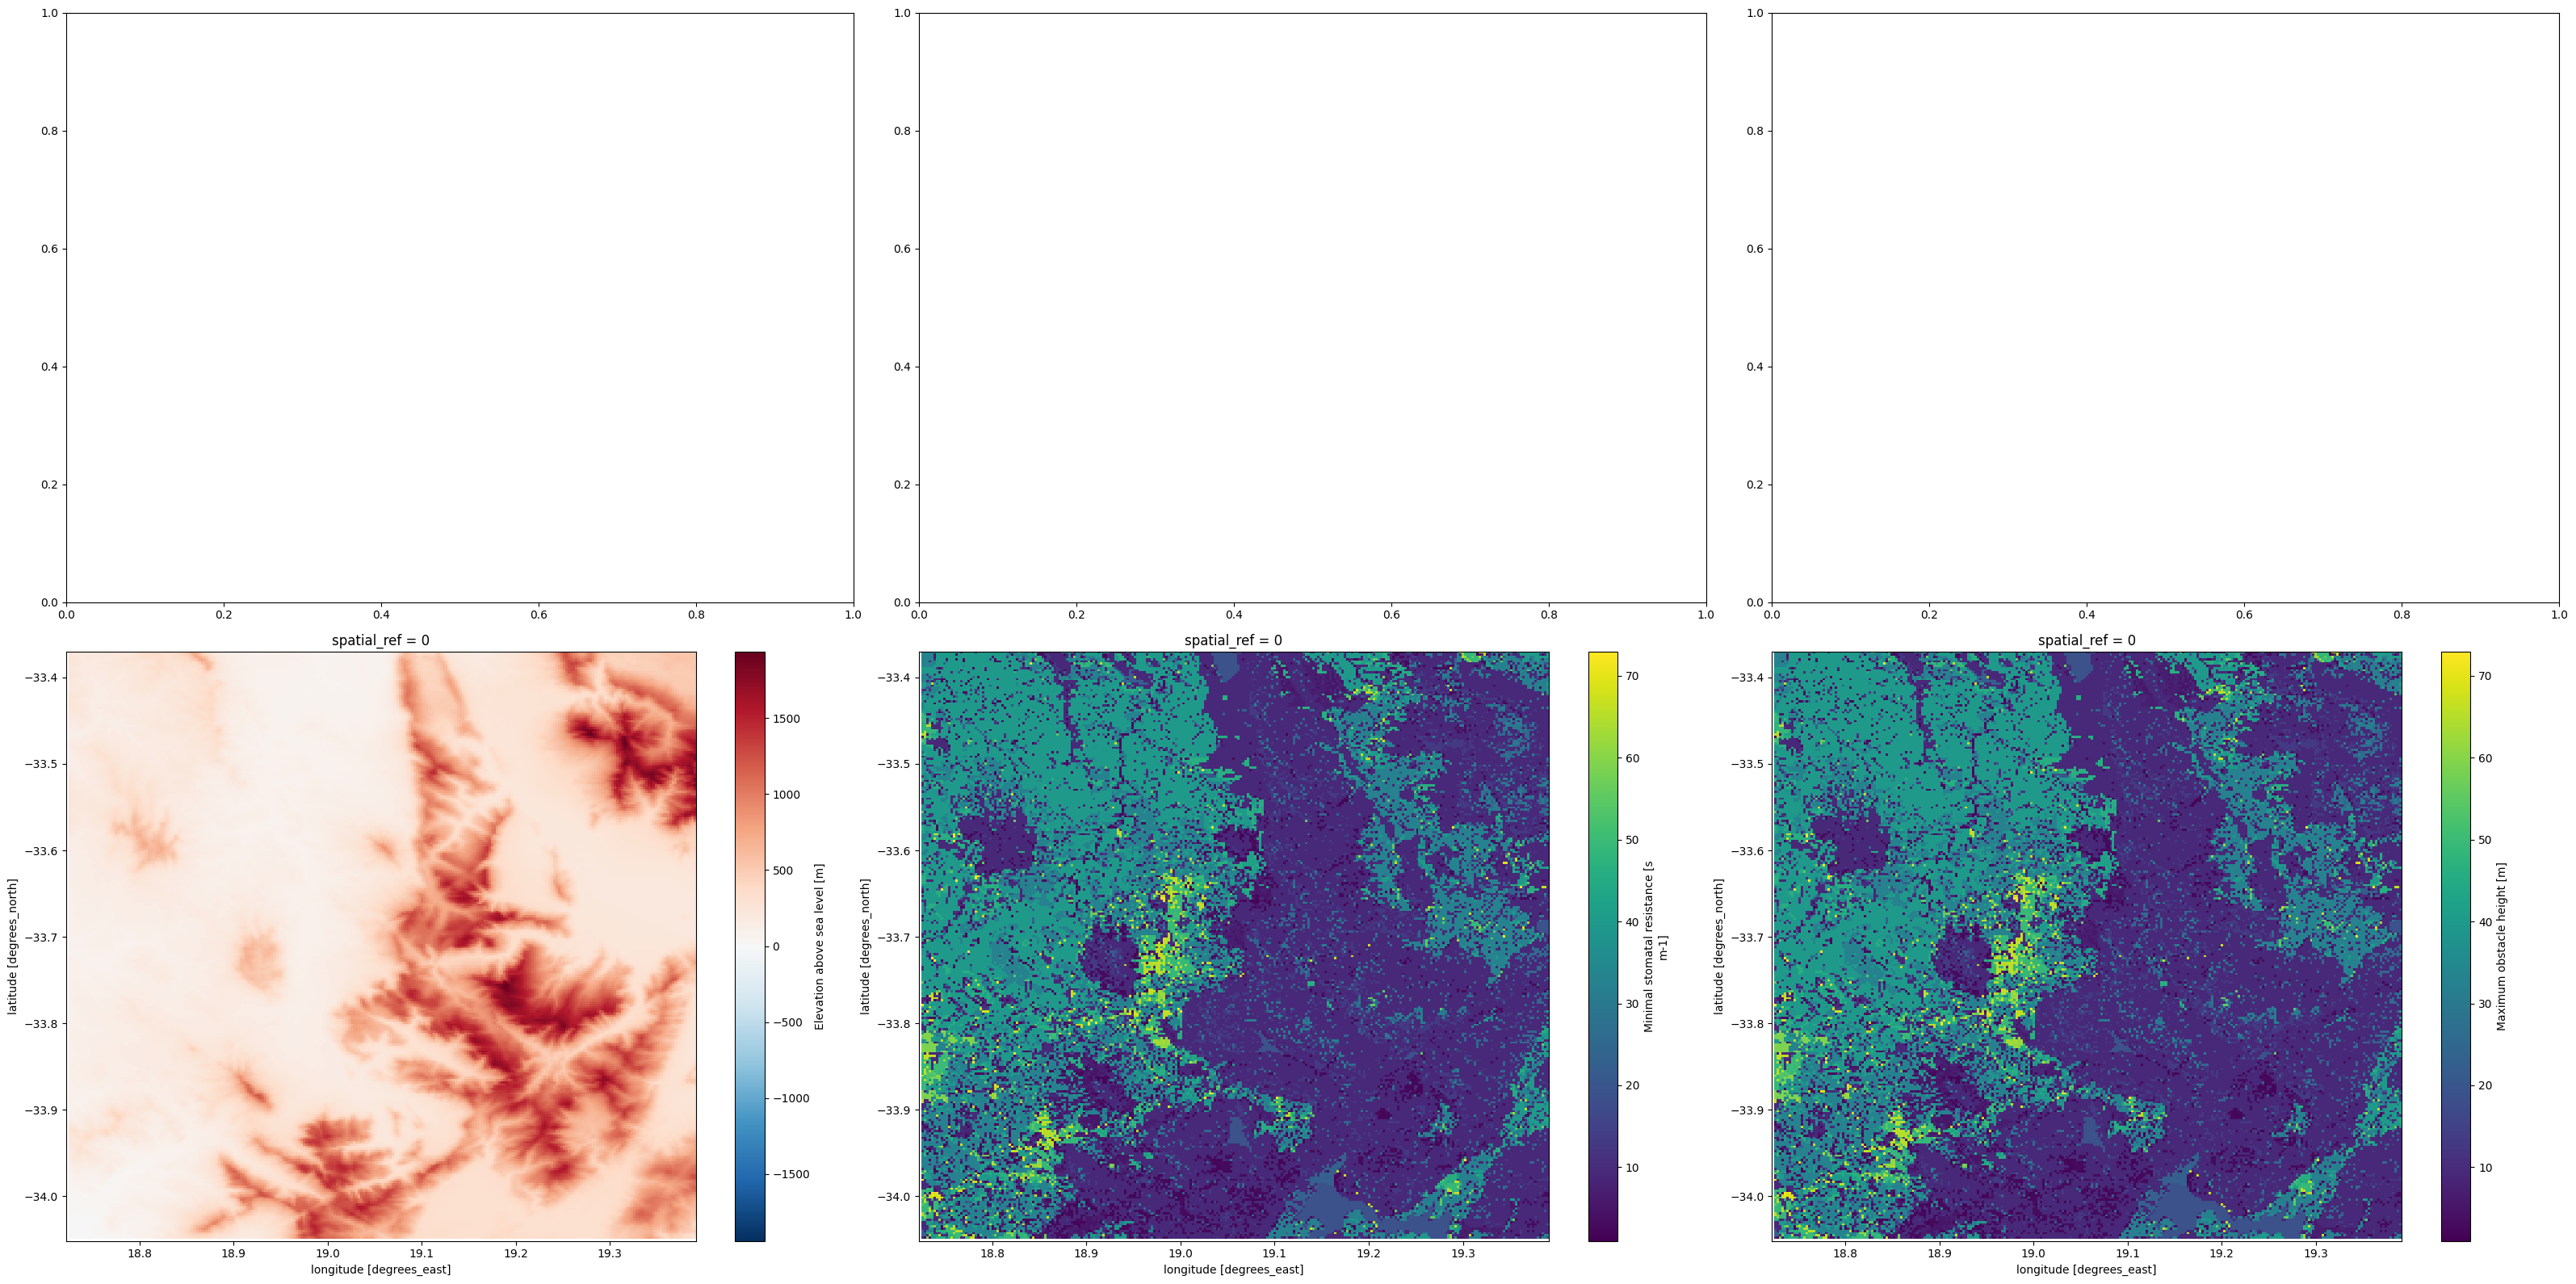

In [83]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(32,16))
# Make a map of a 3-dimensional variable, we will have to select for which time.
# ds.z.plot(ax=axes[0,0])
# ds.rs_min.plot(ax=axes[0,1])
# ds.z_obst_max.plot(ax=axes[0,2])

custom_input_ds.z.plot(ax=axes[1,0])
custom_input_ds.rs_min.plot(ax=axes[1,1])
custom_input_ds.z_obst_max.plot(ax=axes[1,2])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [84]:
# Run et_look
custom_output_ds = pywapor.et_look.main(custom_input_ds)

            > ET_LOOK
                --> Running `et_look` (v2).
                --> Calculating `declination`.
                --> Calculating `inverse_earth_sun_distance`.
                --> Calculating `vegetation_cover`.
                --> Calculating `leaf_area_index`.
                --> Calculating `effective_leaf_area_index`.
                --> Calculating `soil_fraction`.
                --> Calculating `latitude_rad`.
                --> Calculating `sunset_hour_angle`.
                --> Calculating `daily_solar_radiation_toa_flat`.
                --> Calculating `transmissivity`.
                --> Calculating `stress_radiation`.
                --> Calculating `air_pressure_kpa2mbar`.
                --> Calculating `air_pressure_daily`.
                --> Calculating `air_pressure`.
                --> Calculating `vapour_pressure_from_specific_humidity_daily`.
                --> Calculating `vapour_pressure_from_specific_humidity`.
                --> Calculatin

In [85]:
custom_output_ds

<xarray.Dataset>
Dimensions:       (time_bins: 1, y: 266, x: 261)
Coordinates:
  * x             (x) float64 18.72 18.73 18.73 18.73 ... 19.38 19.39 19.39
  * y             (y) float64 -33.37 -33.37 -33.38 ... -34.05 -34.05 -34.05
    spatial_ref   int64 ...
  * time_bins     (time_bins) datetime64[ns] 2023-01-01
Data variables:
    int_mm        (time_bins, y, x) float64 dask.array<chunksize=(1, 266, 261), meta=np.ndarray>
    t_24_mm       (time_bins, y, x) float64 dask.array<chunksize=(1, 266, 261), meta=np.ndarray>
    e_24_mm       (time_bins, y, x) float64 dask.array<chunksize=(1, 266, 261), meta=np.ndarray>
    et_24_mm      (time_bins, y, x) float64 dask.array<chunksize=(1, 266, 261), meta=np.ndarray>
    et_ref_24_mm  (time_bins, y, x) float64 dask.array<chunksize=(1, 266, 261), meta=np.ndarray>
    se_root       (time_bins, y, x) float64 dask.array<chunksize=(1, 266, 261), meta=np.ndarray>
    npp           (time_bins, y, x) float64 dask.array<chunksize=(1, 266, 261), meta=np.ndarray>

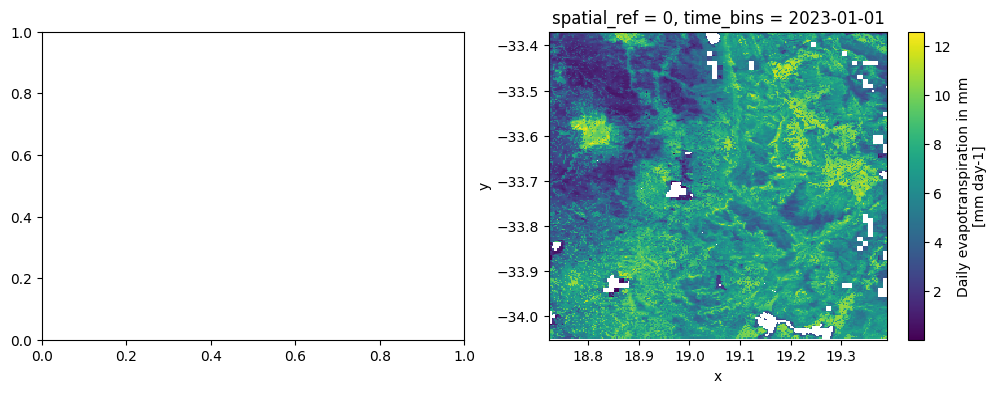

In [86]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
# Plot the daily evapotranspiration in mm
# ds_out.et_24_mm.isel(time_bins = 0).plot(ax=axes[0])
custom_output_ds.et_24_mm.isel(time_bins = 0).plot(ax=axes[1])